In [2]:
import pandas
import os
import sys
import csv
import matplotlib
#matplotlib.use('Agg') 
import matplotlib.pyplot as plt
import numpy as np
import time
import calendar
import ROOT as r
from BlindersPy3 import Blinders
from BlindersPy3 import FitType
import math

Welcome to JupyROOT 6.12/06


In [3]:
file = "./data/gm2nearline_histsOnly_run24795.root"
f = r.TFile(file) #eventually get from command line
runNum = int(file.split("run")[1].split(".")[0])
print("Starting run:", runNum)

Starting run: 24795


In [4]:
f.ls()

TFile**		./data/gm2nearline_histsOnly_run24795.root	
 TFile*		./data/gm2nearline_histsOnly_run24795.root	
  KEY: TDirectoryFile	nearlineHistTree;1	nearlineHistTree (CaloNearlineHistograms) folder
  KEY: TDirectoryFile	clusterTree;1	clusterTree (ClusterTree) folder
  KEY: TDirectoryFile	t0Analyzer;1	t0Analyzer (T0PulseProcessorAnalyzer) folder
  KEY: TDirectoryFile	ibmsAnalyzer;1	ibmsAnalyzer (IBMSAnalyzer) folder
  KEY: TDirectoryFile	CoincidenceFinderLM;1	CoincidenceFinderLM (CoincidenceFinderLM) folder
  KEY: TDirectoryFile	FastRotation;1	FastRotation


In [5]:
allCaloWiggle = f.Get("nearlineHistTree").Get("allCaloWiggle").Clone()
allCaloWiggle.SetTitle("T-Method [E > 1700 MeV] For All Calorimeters")
allCaloWiggle.GetXaxis().SetLimits(allCaloWiggle.GetXaxis().GetXmin() / 1000 * 1.25,allCaloWiggle.GetXaxis().GetXmax() / 1000 * 1.25)
allCaloWiggle.GetXaxis().SetTitle("Time [#mus]")

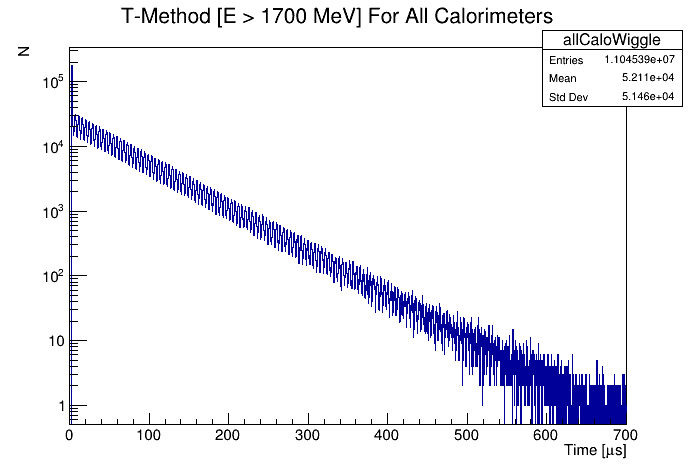

In [6]:
c = r.TCanvas()
allCaloWiggle.Draw()
c.SetLogy()
c.Draw()

In [10]:
print(allCaloWiggle.GetEntries())

11045392.0


In [7]:
# blinded instance
getBlinded = Blinders(FitType.Omega_a, 'This is a special nearline blinding phrase... Nobody peek!')
def blinded_wiggle(x, p):
    norm  = p[0]
    life  = p[1]
    asym  = p[2]
    R     = p[3]
    phi   = p[4]
    
    time  = x[0]
    omega = getBlinded.paramToFreq(R)
    
    return norm * math.exp(-time/life) * (1 - asym*math.cos(omega*time + phi))

 + ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ +
 +                                                                      +
 +           You have chose to blind your fitting according to          +
 +                omega_ref * (1 + (R +/- deltaR) *10^{-6})             +
 +                                                                      +
 + ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ +


In [8]:
func = r.TF1("func", blinded_wiggle, 30,600,5)
func.SetParNames('N','#tau','A','R','#phi')
func.SetParameters(700000,64.4,0.4,0,0)
func.SetParLimits(4,-0.001 - 2*math.pi,2*math.pi+0.001)
func.SetLineColor(2)
func.SetNpx(2000)

0.0 700.0
Sarting fit: 1
 FCN=4143.3 FROM MINOS     STATUS=SUCCESSFUL     36 CALLS         563 TOTAL
                     EDM=4.33701e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  N            2.58977e+04   1.74157e+01  -1.80359e-03  -4.26054e-09
   2  #tau         6.42646e+01   2.43267e-02  -4.56842e-06   4.47854e-06
   3  A            3.68400e-01   5.05409e-04  -3.55216e-07   8.76809e-05
   4  R           -6.49454e+01   1.53382e+01   2.44994e-04  -9.40370e-08
   5  #phi        -9.75436e-01   2.51388e-03   2.51388e-03   1.11690e-02


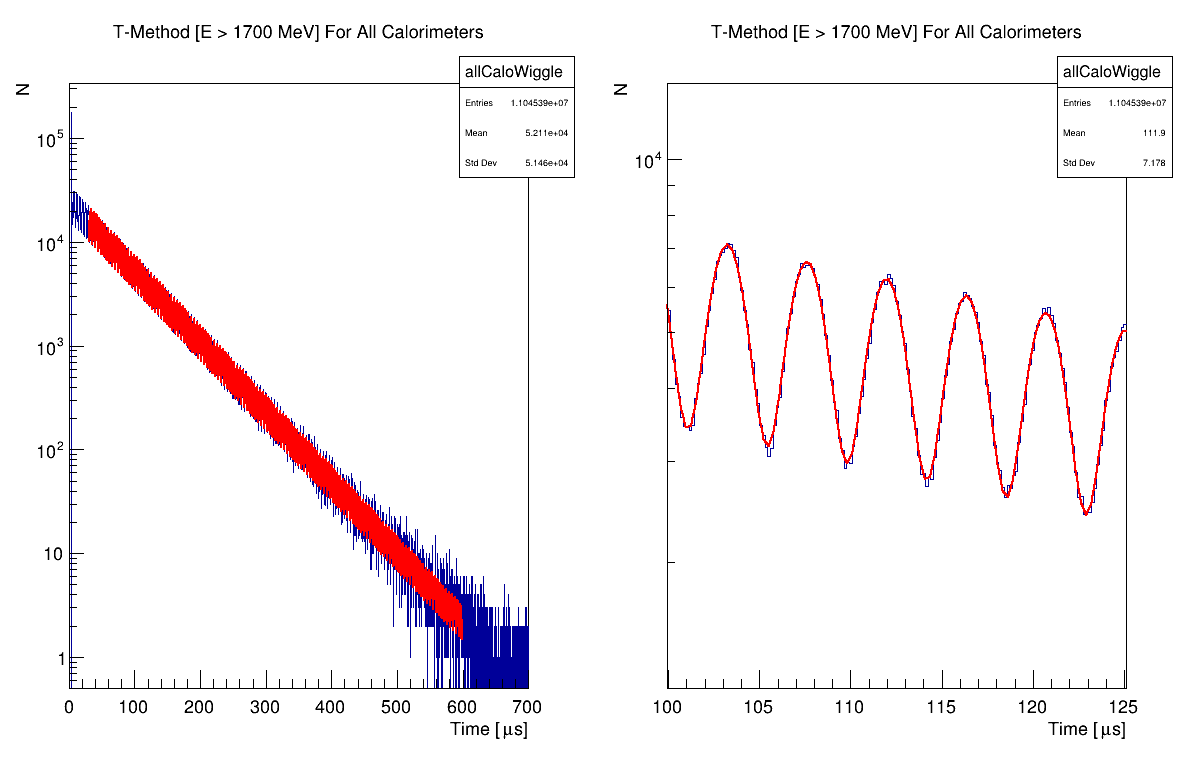

In [9]:
c2 = r.TCanvas("c2","c2",1200,800)
c2.Divide(2,1)
c2.cd(1)
r.gPad.SetLogy()

r.gStyle.SetOptFit(111)

print(allCaloWiggle.GetXaxis().GetXmin(),allCaloWiggle.GetXaxis().GetXmax())

residuals = allCaloWiggle.Clone("5paramResid") # this will be filled with the fit residuals later

for fit in range(1):
    print("Sarting fit:", fit+1)
    allCaloWiggle.Fit("func","REM")
    
paramsAll_5 = []
for i in range(5):
    paramsAll_5.append( (func.GetParameter(i), func.GetParError(i)) )

chiSqAll_5 = [ func.GetNDF(), func.GetChisquare(), func.GetProb() ]
allCaloWiggle.Draw()

c2.cd(2)
ding =  allCaloWiggle.Clone()
ding.GetXaxis().SetRangeUser(100,125)
ding.Draw()

r.gPad.SetLogy()
c2.Draw()

In [22]:
print(paramsAll_5)

[(25897.697215942448, 17.41570493880238), (64.26455099482469, 0.02432670679403282), (0.36840044912947073, 0.0005054092798798201), (-64.94542052615712, 15.33821163126373), (-0.9754364694489892, 0.0025138779169591174)]


# Now lets try a simple fit to the residuals to extract the CBO term

4700
3828 [(30.010638297872337, -210.22785307606682), (30.159574468085104, -174.75897830825488), (30.30851063829787, 56.348780354956034), (30.457446808510635, -51.52256432707691), (30.606382978723403, -157.5319386954834)]
3828 569.9787234042552 29.93618966628871 599.9149130705439
0.1488972631672558 0.0017544514539549819
13.43208033147934 6.71604016573967


Warning in <TFile::Append>: Replacing existing TH1: htest (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: out_MAG P (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: out_MAG P (Potential memory leak).


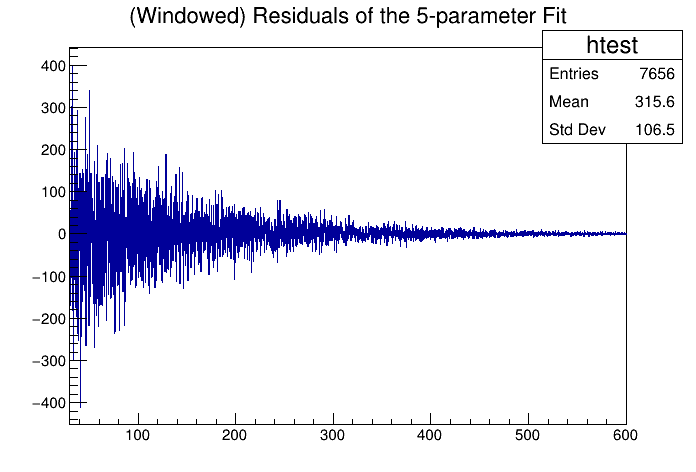

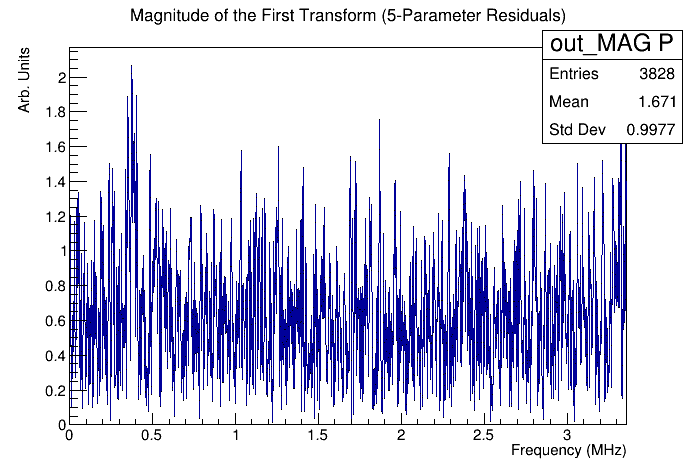

In [21]:
c3 = r.TCanvas()
residuals5param = residuals.Clone() # this will hold the residials from the 5-parameter fit
nBins = residuals5param.GetSize() - 2 #total number of bins excluding over/underflow
print(nBins)
residVec = []
for i in range(nBins):
    binCenterX = allCaloWiggle.GetXaxis().GetBinCenter(i)
    if (binCenterX > 30 and binCenterX < 600):
        residVec.append( (binCenterX, allCaloWiggle.GetBinContent(i) - func.Eval(binCenterX) ) )
        residuals5param.SetBinContent(i, allCaloWiggle.GetBinContent(i) - func.Eval(binCenterX))
    else:
        residuals5param.SetBinContent(i, 0)

print(len(residVec),[residVec[i] for i in range(5)])
centers, bins = zip(*residVec)
htest = r.TH1D("htest","htest",len(residVec),centers[0],centers[len(residVec)-1])
for i,ding in enumerate(bins):
    htest.SetBinContent(i, ding)
    
residuals5param.Delete()
residuals5param = htest
nBins = residuals5param.GetSize() - 2 #total number of bins excluding over/underflow

#apply a windows function to try to get rid of the imaginary peaks
welchVec = []
for i in range(nBins):
    unwindowed = residuals5param.GetBinContent(i)
    welch = 1 #- ( ( i - (nBins - 1) / 2) / ((nBins - 1) / 2) )**2
    welchVec.append(welch)
    residuals5param.SetBinContent(i, unwindowed *  welch)
    
residuals5param.Draw()
residuals5param.GetXaxis().SetRangeUser(30,700)
residuals5param.SetTitle("(Windowed) Residuals of the 5-parameter Fit")
c3.Draw()    
    
hxform = r.TH1D()
hxform = 0
r.TVirtualFFT.SetTransform(0)
hxform = residuals5param.FFT(hxform,"MAG P")
hxform.SetTitle("Magnitude of the First Transform (5-Parameter Residuals)")
#NOTE: for "real" frequencies you have to divide the x-axes range with the range of your function
#    y-axes has to be rescaled by a factor of 1/SQRT(n) to be right: this is not done automatically!
normXform = hxform.GetEntries()
hxform.Scale(1/normXform)
c2 = r.TCanvas()
c2.cd()
#c2.SetLogy()
hxform.GetXaxis().SetTitle("Frequency (MHz)")
hxform.GetYaxis().SetTitle("Arb. Units")
hxform.Draw("HIST P0 L")
c2.Draw()

Npart = residuals5param.GetSize() - 2
minBinCenter = residuals5param.GetXaxis().GetBinCenter(0)
maxBinCenter = residuals5param.GetXaxis().GetBinCenter(Npart)

capT = maxBinCenter - minBinCenter
print(Npart, capT, minBinCenter, maxBinCenter)
deltaT = capT/Npart #microseconds
deltaF = 1/capT
print(deltaT, deltaF)

deltaTns = deltaT*1000 #nanoseconds
limmaxHz = (1/(deltaTns*math.pow(10.0,-9)))
limmaxMHz = limmaxHz / math.pow(10.0,6)

limmax = 2*deltaF*Npart #400-25
print(limmax,limmaxMHz)
#hxform.GetXaxis().SetLimits(0,limmax)
nbins = residuals5param.GetSize() - 2
hxform.SetBins(Npart,0,limmaxMHz)
hxform.GetXaxis().SetRangeUser(0,limmaxMHz/2)
#hxform.GetXaxis().SetRangeUser(0,1.4)

residuals5paramXform = hxform.Clone()

#c2.SetLogy()
c2.Draw()

# Not even enough power to be worth trying... Maybe we'll be able to fit something directly

In [12]:
def blinded_wiggle_cbo(x, p):
    norm     = p[0]
    life     = p[1]
    asym     = p[2]
    R        = p[3]
    phi      = p[4]
    A1       = p[5]
    #A2       = p[6]
    #A3       = p[7]
    lifeCBO  = p[6]
    omegaCBO = p[7]
    phiCBO1  = p[8]
    #phiCBO2  = p[11]
    #phiCBO3  = p[12]
    
    time  = x[0]
    omega = getBlinded.paramToFreq(R)
    
    cCBO = 1-math.exp(-time/lifeCBO)*A1*math.cos(omegaCBO*time + phiCBO1)
    ACBO = asym #* (1 - math.exp(-time/lifeCBO) * A2 * math.cos(omegaCBO*time + phiCBO2))
    phiCBO = phi # + math.exp(-time/lifeCBO)*A3*math.cos(omegaCBO*time + phiCBO3)
    
    return norm * math.exp(-time/life) * cCBO * (1 - ACBO*math.cos(omega*time + phiCBO))

In [18]:
func9 = r.TF1("func9", blinded_wiggle_cbo, 30, 600, 9)
func9.SetParNames('N','#tau','A',
                   'R','#phi','A_{1}',
                   '#tau_{CBO}', '#omega_{CBO}','#phi_{CBO - 1}')
func9.SetParLimits(6,0.0000001,100000000) #Avoid divide by 0 error
for i in range(5):
    func9.SetParameter(i, func.GetParameter(i))
func9.SetParameter(5,1)
func9.SetParameter(6,1)
func9.SetParameter(7,1)
func9.SetParameter(8,1)
func9.SetLineColor(4)
func9.SetNpx(2000)

0.0 700.0
Sarting fit: 1
 FCN=4109.01 FROM MINOS     STATUS=SUCCESSFUL   1299 CALLS        7826 TOTAL
                     EDM=1.54553e-06    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  N            2.59009e+04   1.75093e+01  -3.60477e-03  -2.05914e-06
   2  #tau         6.42614e+01   2.43919e-02   3.59834e-06  -5.10527e-04
   3  A            3.68359e-01   5.06371e-04   3.68923e-08   5.11544e-02
   4  R           -5.96795e+01   1.55126e+01  -5.77553e-03   1.95092e-06
   5  #phi        -9.76643e-01   2.56897e-03   1.32239e-06   4.40332e-02
   6  A_{1}        1.42059e-01   2.33834e-01  -1.24315e-04   8.30214e-02
   7  #tau_{CBO}   1.18318e+01   6.37096e+00  -2.33522e-08** at limit **
   8  #omega_{CBO}   2.35800e+00   3.80267e-02   2.92140e-05   5.21796e-01
   9  #phi_{CBO - 1}  -4.14169e+01   1.35480e+00   1.35480e+00   3.21488e-03


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c2


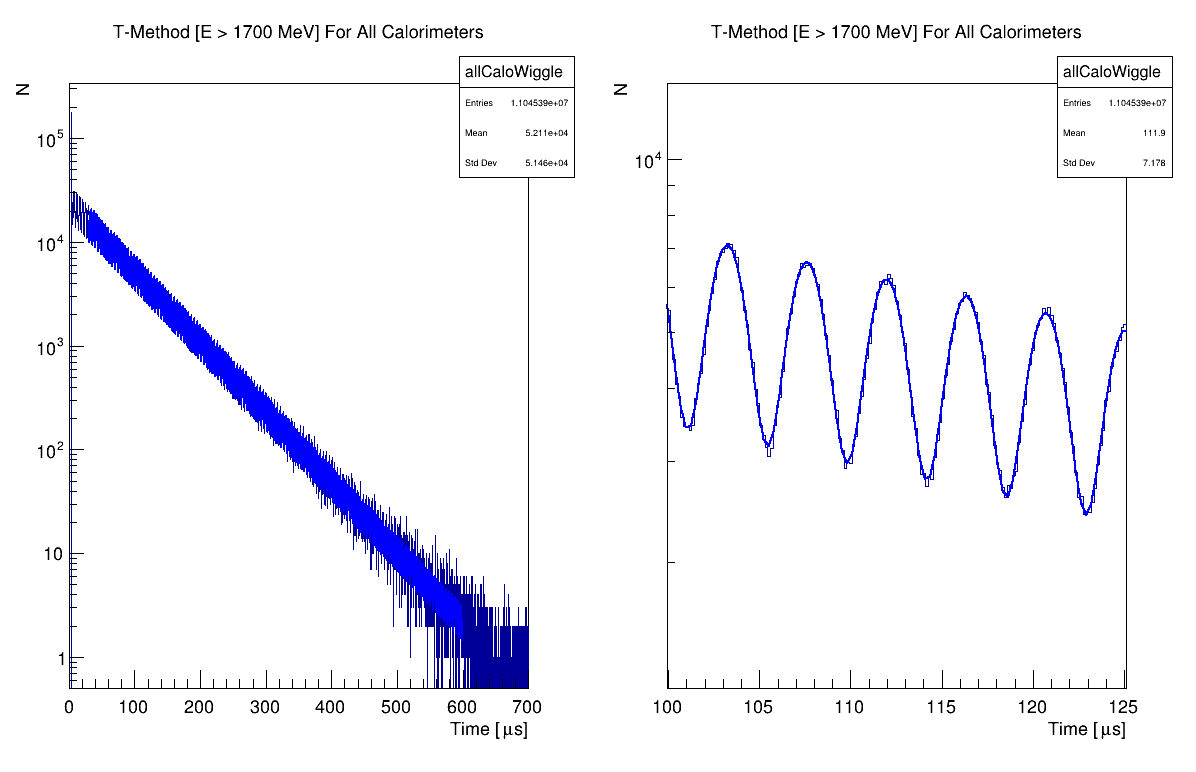

In [19]:
c2 = r.TCanvas("c2","c2",1200,800)
c2.Divide(2,1)
c2.cd(1)
r.gPad.SetLogy()

r.gStyle.SetOptFit(111)

print(allCaloWiggle.GetXaxis().GetXmin(),allCaloWiggle.GetXaxis().GetXmax())

residuals9 = allCaloWiggle.Clone("9paramResid") # this will be filled with the fit residuals later

for fit in range(1):
    print("Sarting fit:", fit+1)
    allCaloWiggle.Fit("func9","REM")
    
paramsAll_9 = []
for i in range(9):
    paramsAll_9.append( (func9.GetParameter(i), func9.GetParError(i)) )


chiSqAll_9 = [ func9.GetNDF(), func9.GetChisquare(), func9.GetProb() ]
allCaloWiggle.Draw()

c2.cd(2)
ding =  allCaloWiggle.Clone()
ding.GetXaxis().SetRangeUser(100,125)
ding.Draw()

r.gPad.SetLogy()
c2.Draw()

In [20]:
print(paramsAll_9)

[(25900.913495152538, 17.188656613985486), (64.26135247128057, 0.023935040289555863), (0.36835942702032126, 0.0005045525815661502), (-59.67948158171577, 15.290039882770074), (-0.9766428993791647, 0.0025449574647583985), (0.14205946437861944, 0.3563930794076707), (11.83179855765102, 9.69870232736535), (2.3580039352002538, 0.0322438446713546), (-41.41693372003638, 1.1435157853267564)]
